In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import glob
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def cubic_spline_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                cubic_spline = CubicSpline(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = cubic_spline(x)
                plot_polynomial(cubic_spline, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        moving_averages.append(np.mean(window))
        
    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [5]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('y')
    plt.title(column.name) 
    plt.xticks(rotation=45)
    plt.show()

In [15]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, index_col=False, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: 
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [16]:
df = pd.read_csv("valor_cimento_portland_32.csv")
df

,Ano,Alagoas,Amazonas,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiais-03anhão,Minas Gerais,Mato Grosso do Sul,...,Paraíba,Pernambuco,Paraná,Rio de-01eiro,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Brasil
1995-01,NaN,0.140,0.1100,0.1300,0.110,0.1000,0.110,0.14,0.1100,0.11,...,0.1300,0.13,0.11,0.1100,0.15,0.11,0.1100,NaN,0.1000,0.1179
1995-02,NaN,0.140,0.1100,0.1300,0.110,0.1000,0.110,0.14,0.1100,0.11,...,0.1300,0.13,0.10,0.1100,0.16,0.11,0.1100,NaN,0.1000,0.1184
1995-03,NaN,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.13,0.1100,0.13,...,0.1300,0.13,0.10,0.1100,0.15,0.11,0.1100,NaN,0.1100,0.1195
1995-04,NaN,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.12,0.1100,0.12,...,0.1300,0.13,0.10,0.1100,0.16,0.11,0.1200,NaN,0.1200,0.1205
1995-05,NaN,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.12,0.1100,0.12,...,0.1300,0.13,0.10,0.1100,0.15,0.11,0.1200,NaN,0.1200,0.1205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,0.65,0.795,0.6748,0.6600,0.638,0.5956,0.633,0.68,0.6500,0.72,...,0.5370,0.69,0.66,0.6800,0.97,0.74,0.6320,0.74,0.7124,0.6974
2022-09,0.66,0.830,0.6826,0.6978,0.639,0.6070,0.633,0.68,0.6672,0.72,...,0.6000,0.66,0.66,0.6800,0.96,0.75,0.6328,0.76,0.7086,0.7061
2022-10,0.66,0.860,0.6916,0.6978,0.635,0.6070,0.633,0.68,0.6670,0.72,...,0.5856,0.69,0.66,0.6590,0.96,0.75,0.6334,0.76,0.6966,0.7074
2022-11,0.66,0.900,0.7024,0.6978,0.640,0.6126,0.633,0.68,0.6370,0.72,...,0.6040,0.65,0.67,0.6532,0.94,0.77,0.6334,0.76,0.6964,0.7088


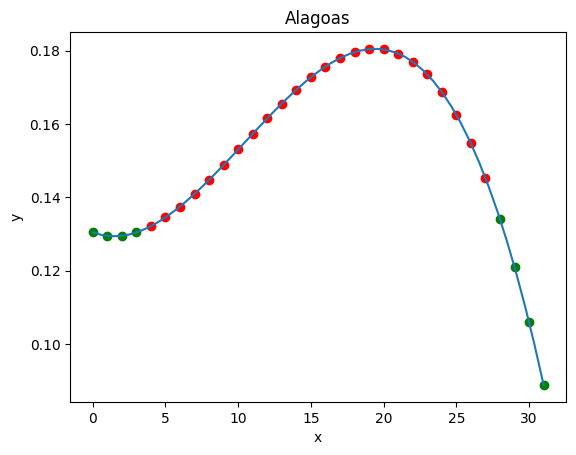

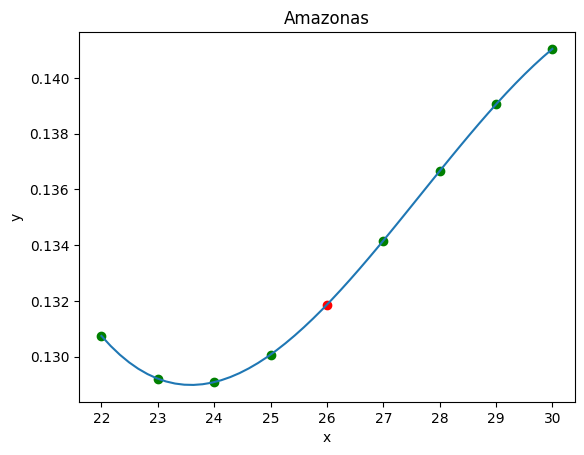

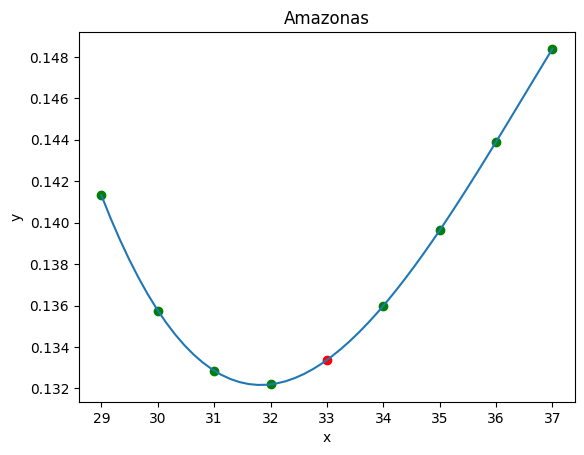

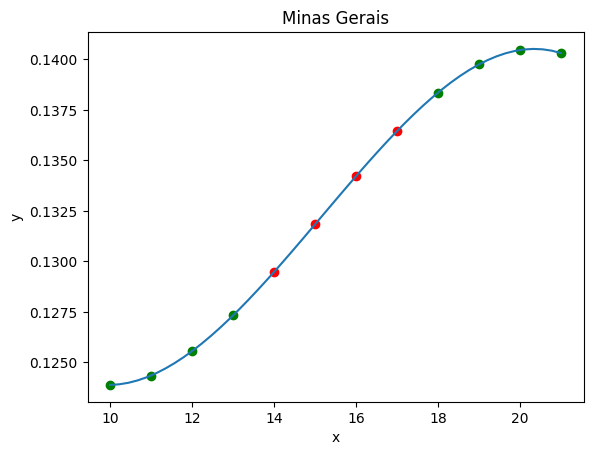

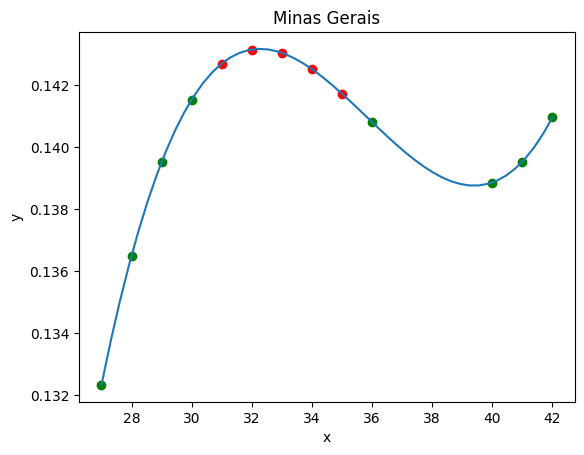

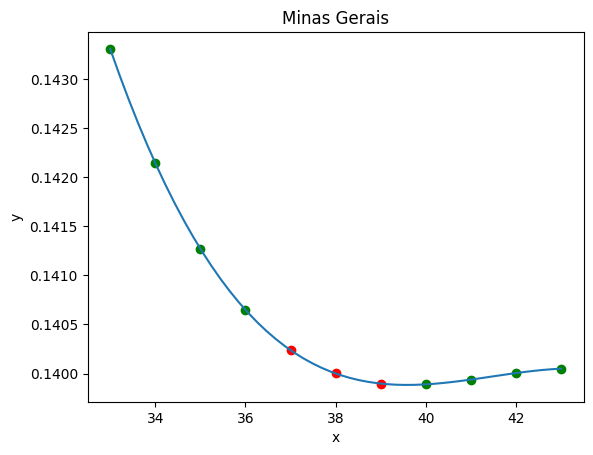

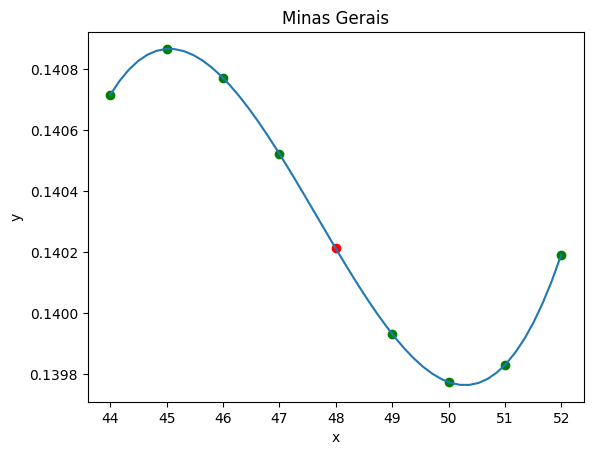

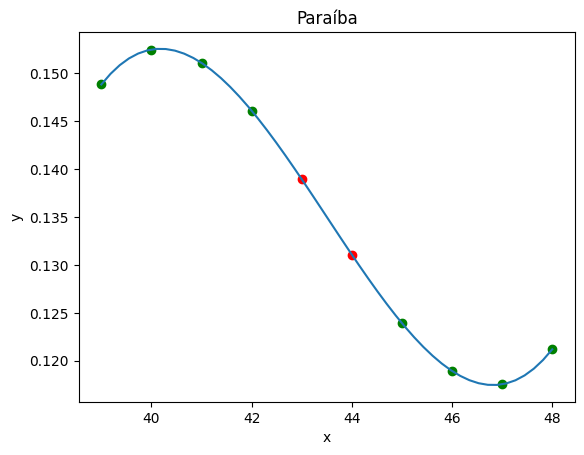

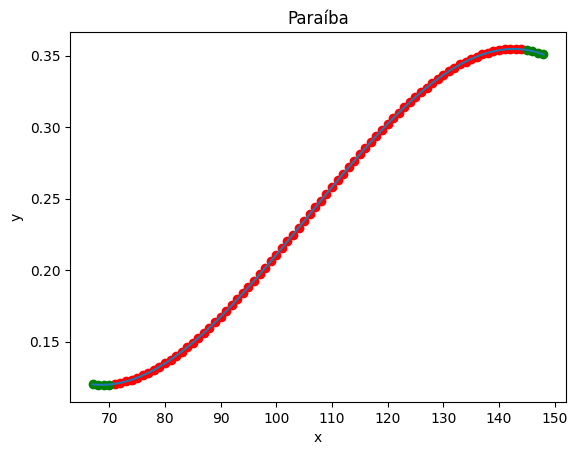

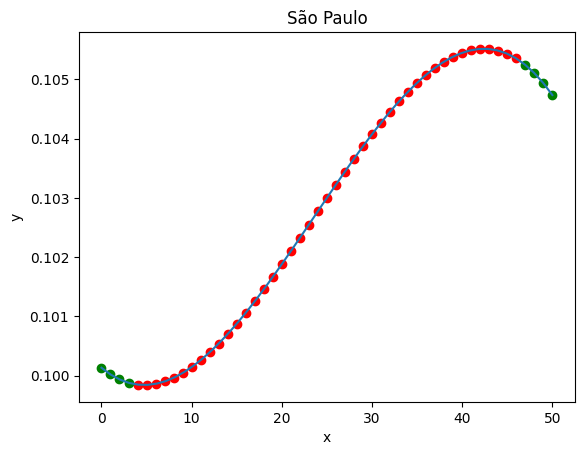

,Ano,Alagoas,Amazonas,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiais-03anhão,Minas Gerais,Mato Grosso do Sul,...,Paraíba,Pernambuco,Paraná,Rio de-01eiro,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Brasil
0,1995-01,0.130000,0.140,0.1100,0.1300,0.110,0.1000,0.110,0.14,0.1100,...,0.1300,0.1300,0.13,0.11,0.1100,0.15,0.11,0.1100,0.10000,0.1000
1,1995-02,0.130000,0.140,0.1100,0.1300,0.110,0.1000,0.110,0.14,0.1100,...,0.1300,0.1300,0.13,0.10,0.1100,0.16,0.11,0.1100,0.10000,0.1000
2,1995-03,0.130000,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.13,0.1100,...,0.1300,0.1300,0.13,0.10,0.1100,0.15,0.11,0.1100,0.10000,0.1100
3,1995-04,0.130000,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.12,0.1100,...,0.1300,0.1300,0.13,0.10,0.1100,0.16,0.11,0.1200,0.10000,0.1200
4,1995-05,0.132158,0.140,0.1200,0.1300,0.110,0.1000,0.120,0.12,0.1100,...,0.1400,0.1300,0.13,0.10,0.1100,0.15,0.11,0.1200,0.09985,0.1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2022-08,0.650000,0.795,0.6748,0.6600,0.638,0.5956,0.633,0.68,0.6500,...,0.7326,0.5370,0.69,0.66,0.6800,0.97,0.74,0.6320,0.74000,0.7124
332,2022-09,0.660000,0.830,0.6826,0.6978,0.639,0.6070,0.633,0.68,0.6672,...,0.7450,0.6000,0.66,0.66,0.6800,0.96,0.75,0.6328,0.76000,0.7086
333,2022-10,0.660000,0.860,0.6916,0.6978,0.635,0.6070,0.633,0.68,0.6670,...,0.7284,0.5856,0.69,0.66,0.6590,0.96,0.75,0.6334,0.76000,0.6966
334,2022-11,0.660000,0.900,0.7024,0.6978,0.640,0.6126,0.633,0.68,0.6370,...,0.7240,0.6040,0.65,0.67,0.6532,0.94,0.77,0.6334,0.76000,0.6964


In [17]:
df = read_csv_replace_missing_by_polynomial("valor_cimento_portland_32.csv", 0)
df

In [20]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('Valor médio Cimento portland 32 (R$/Kg)')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

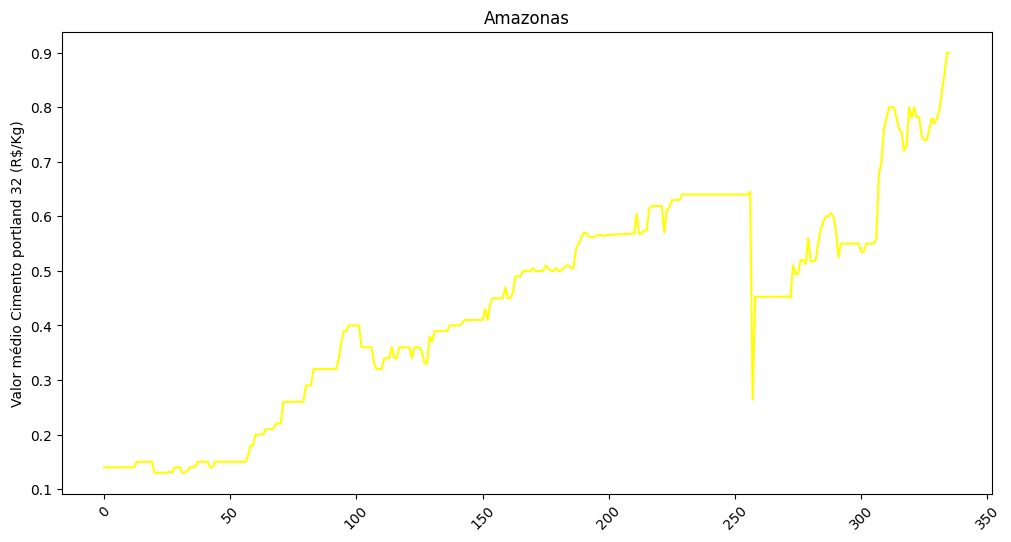

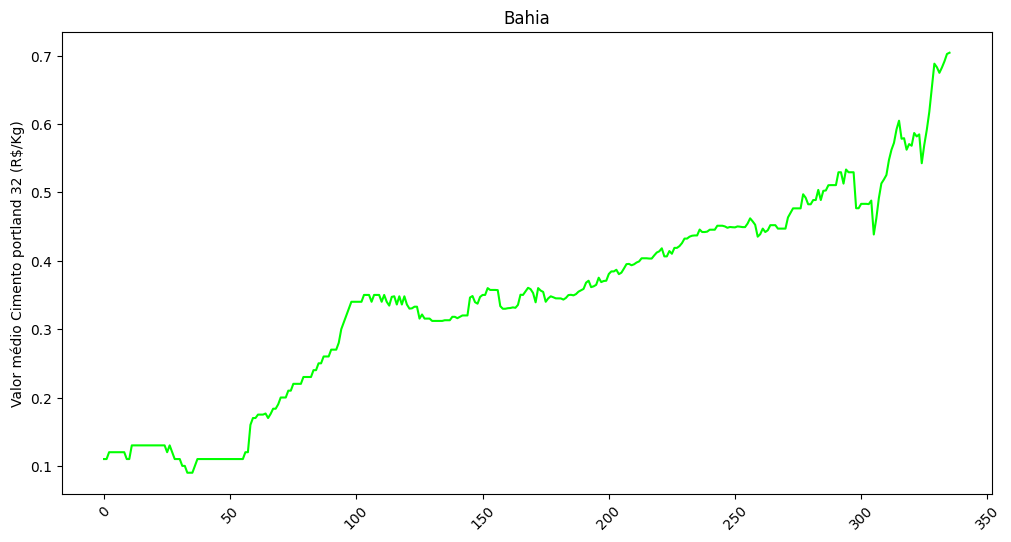

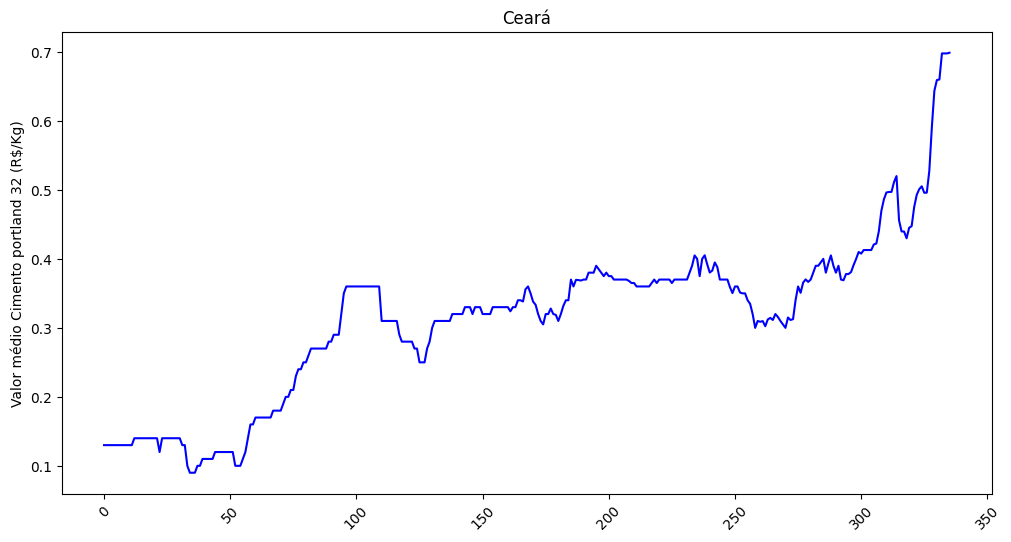

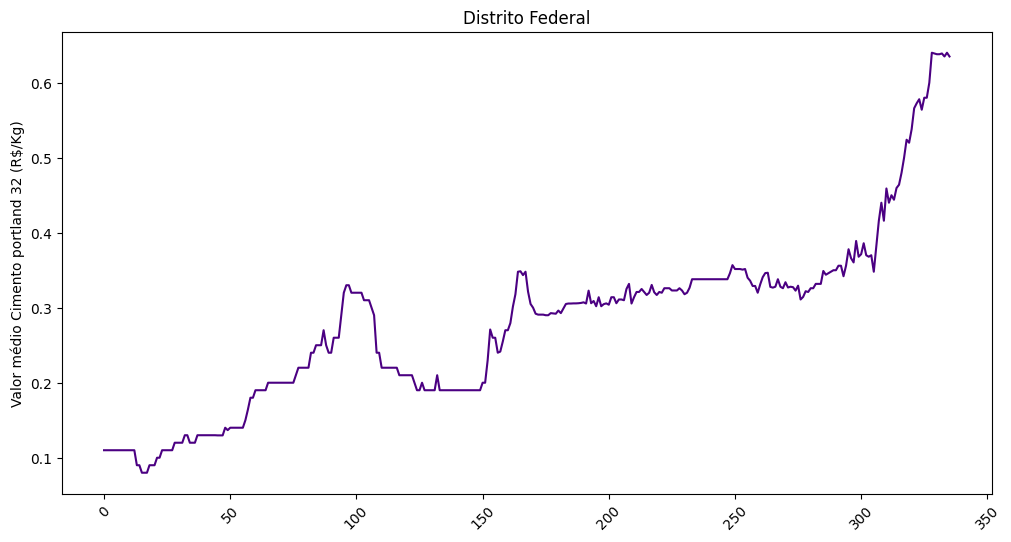

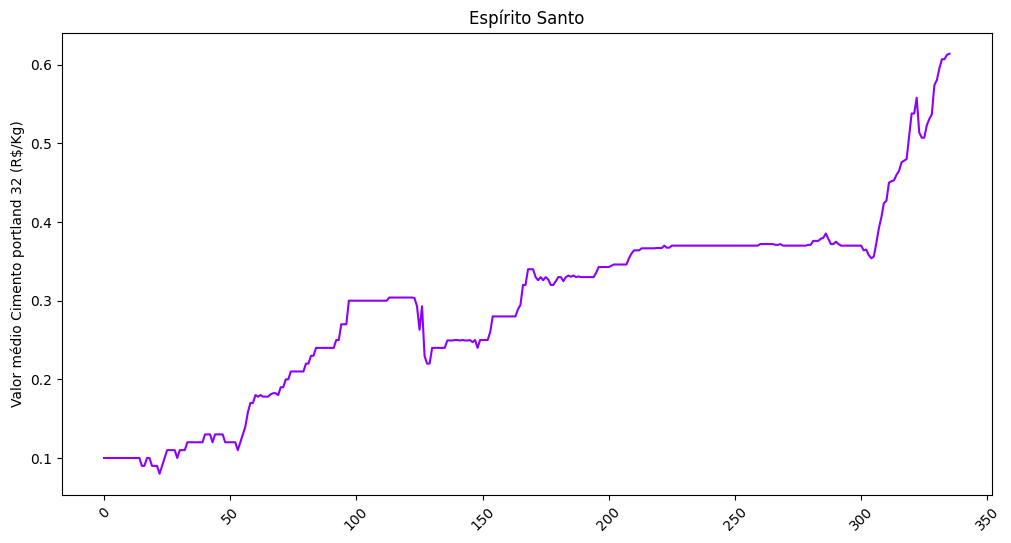

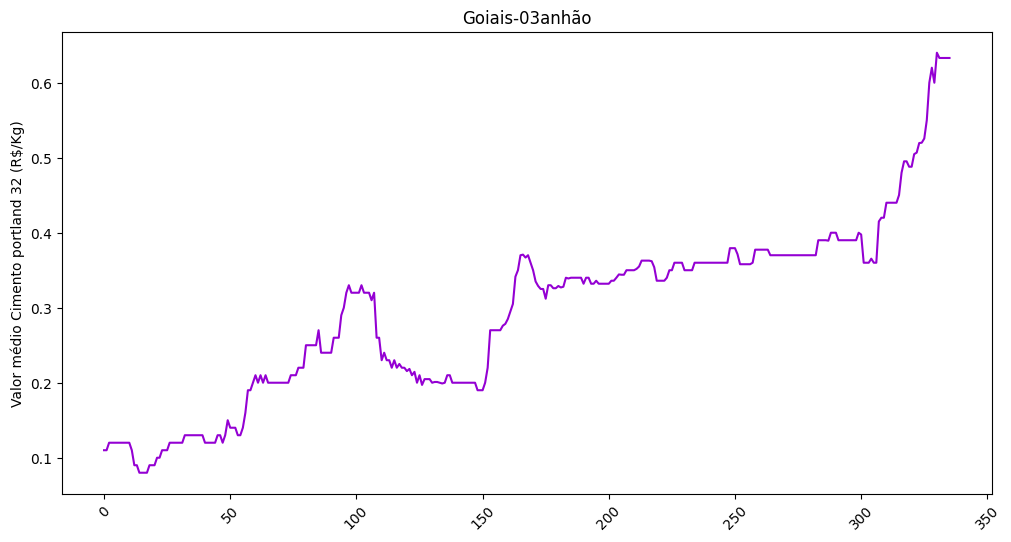

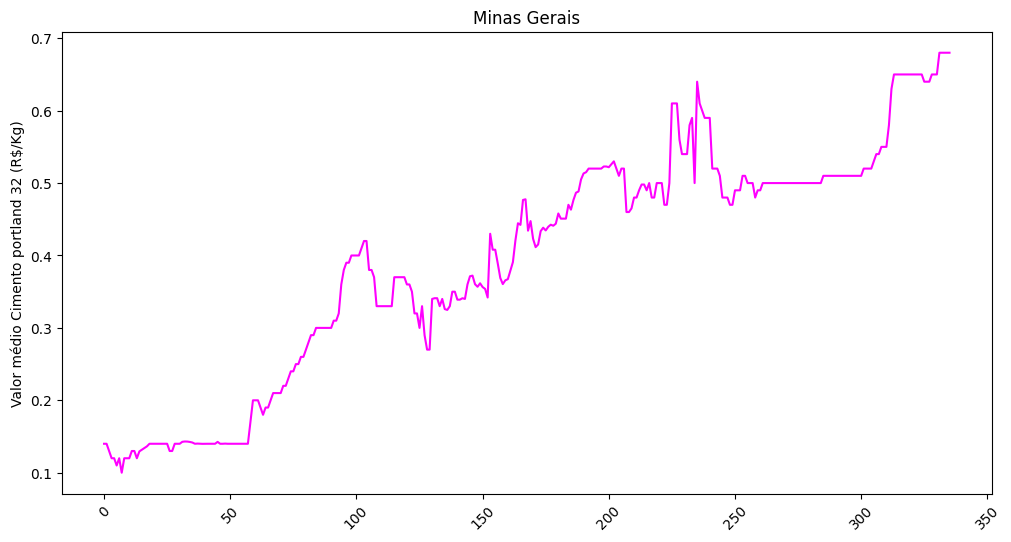

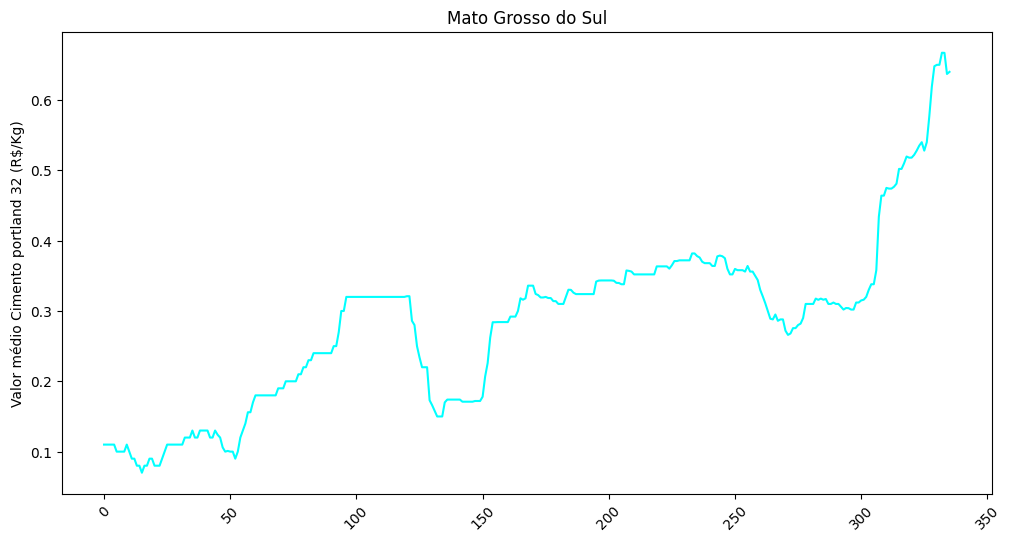

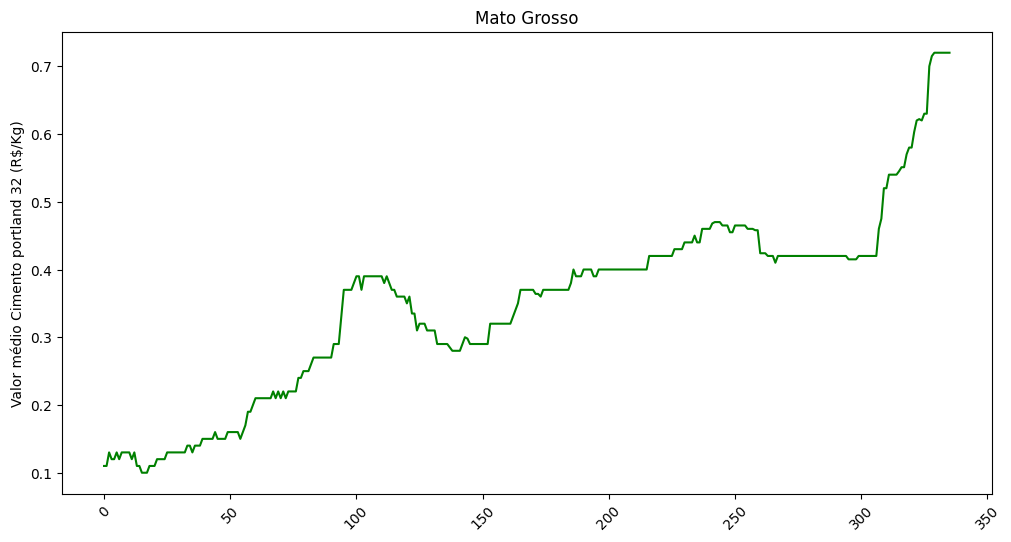

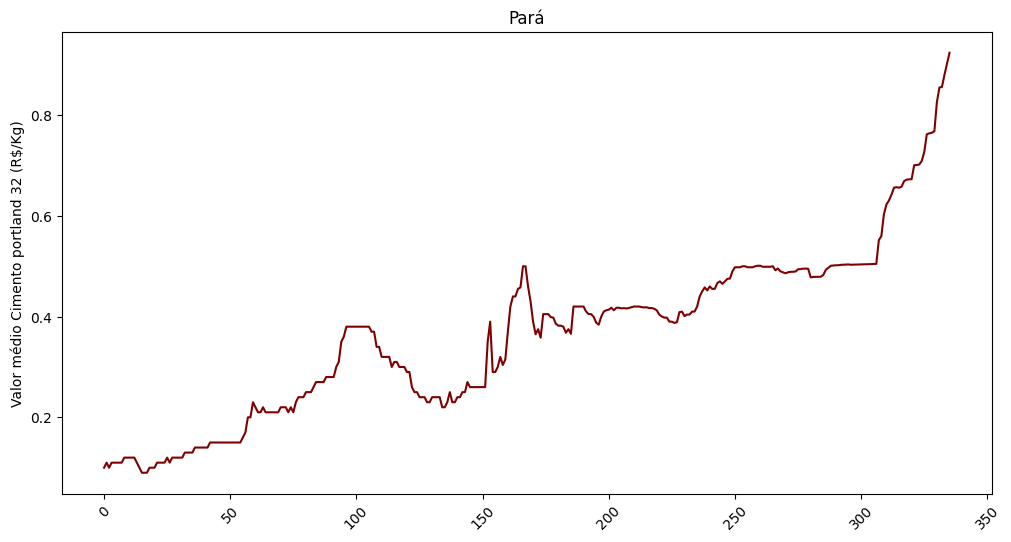

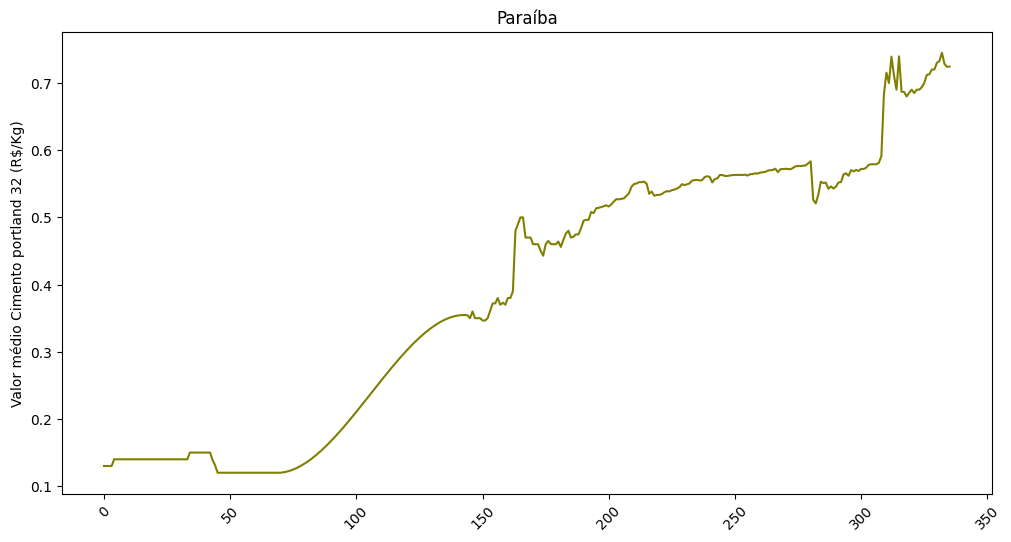

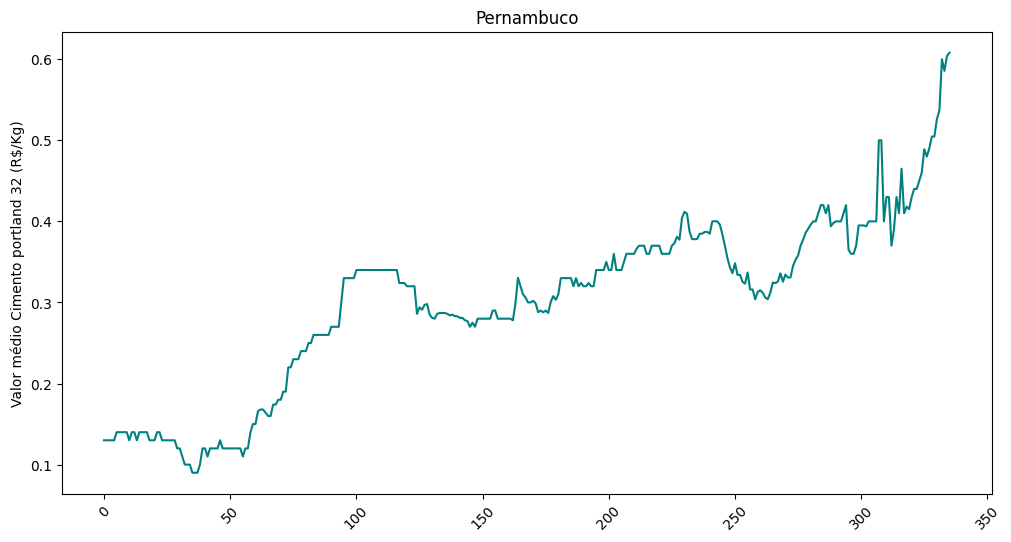

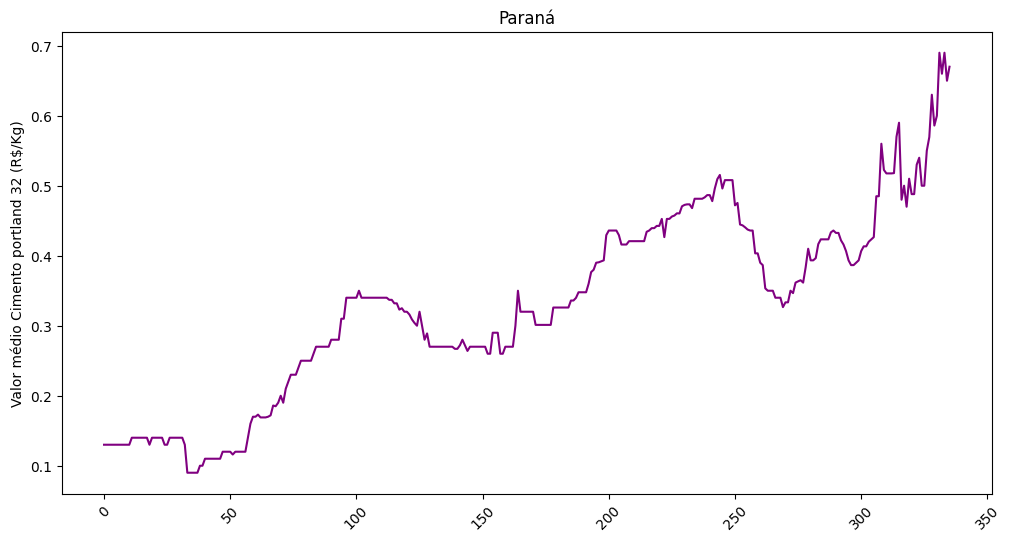

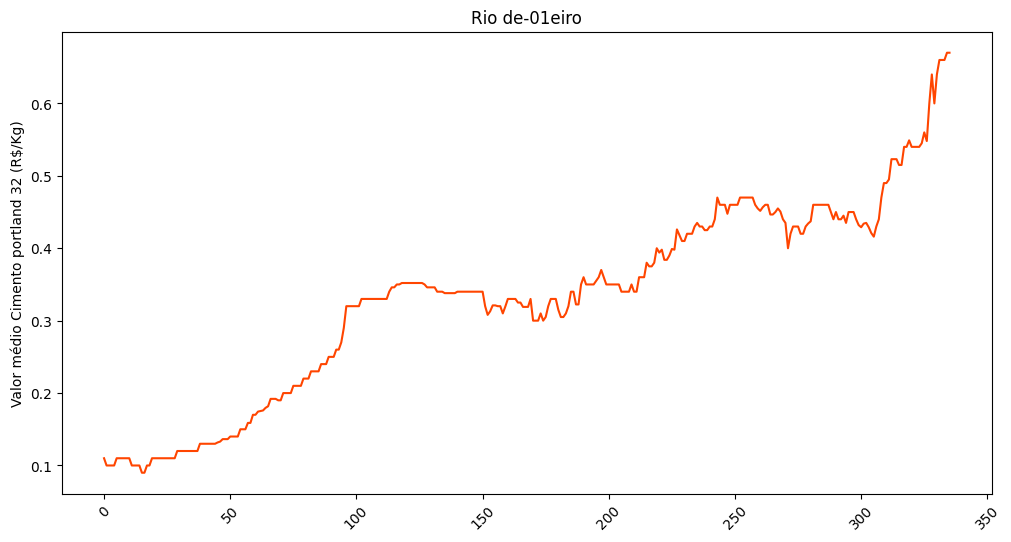

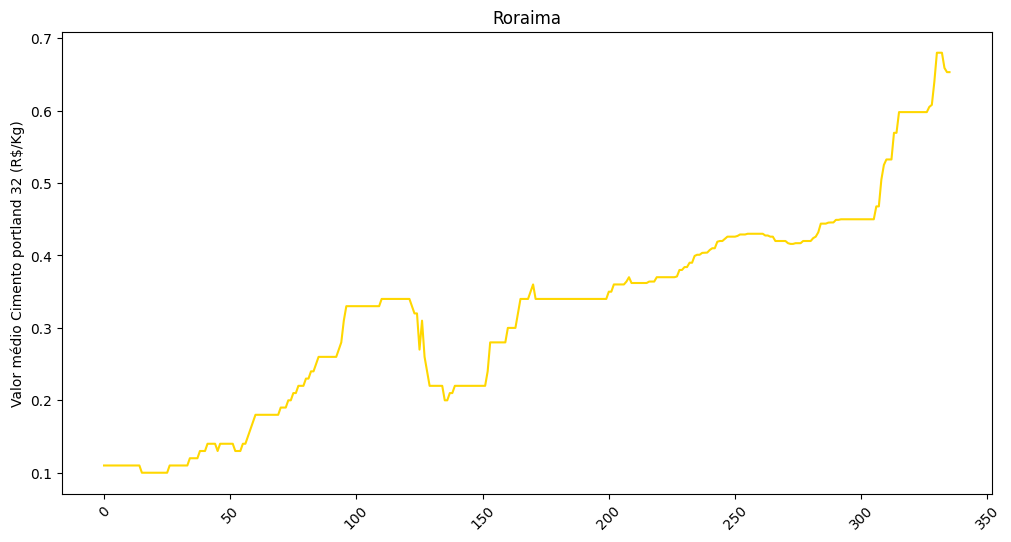

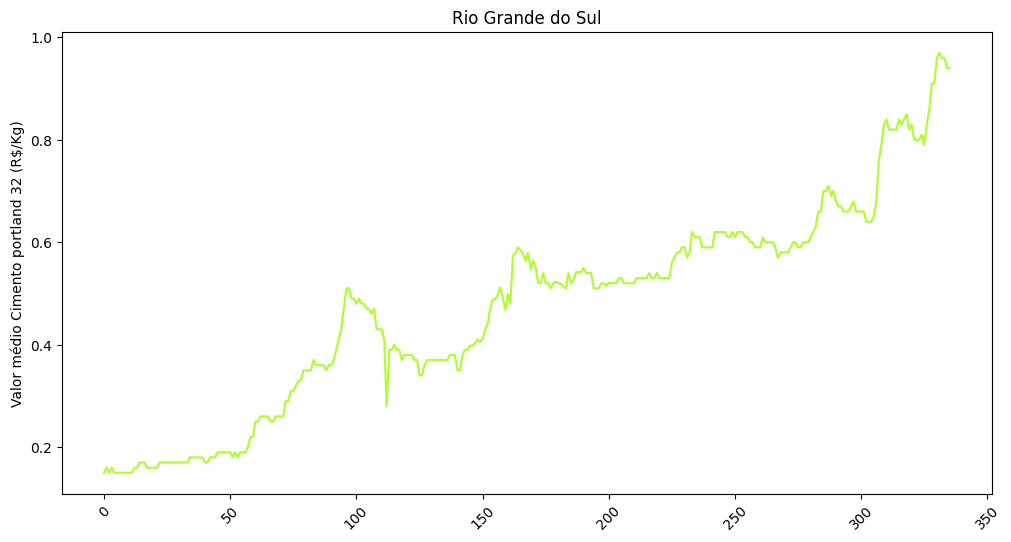

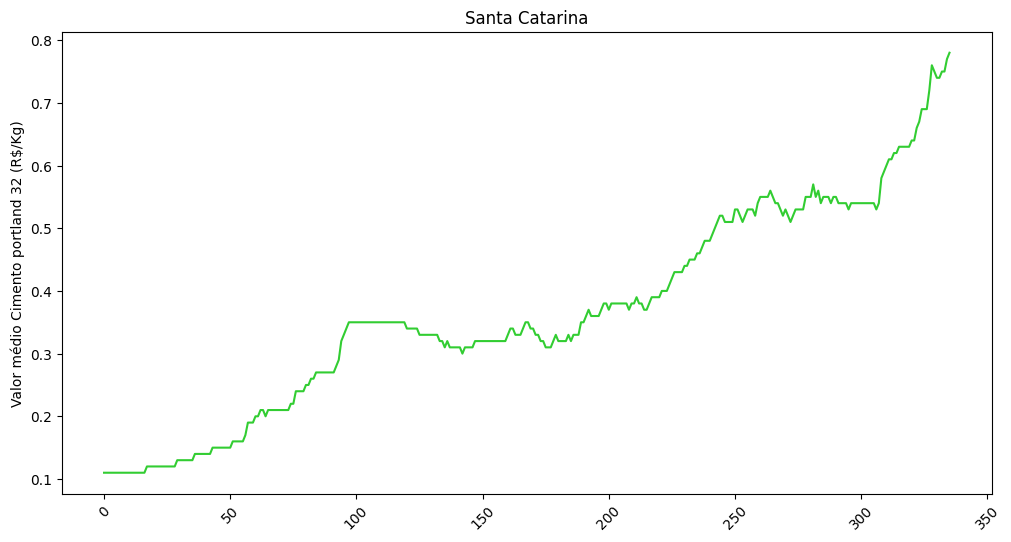

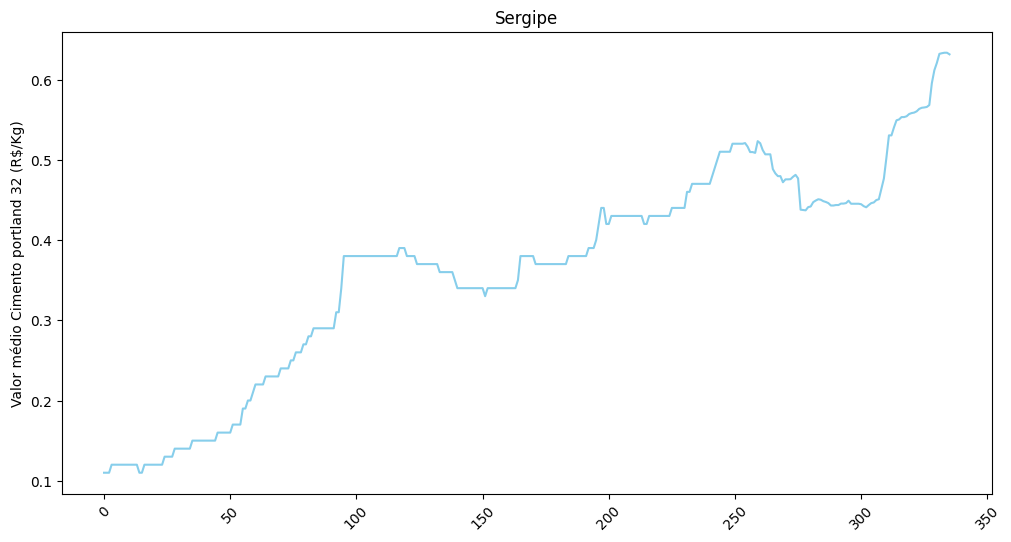

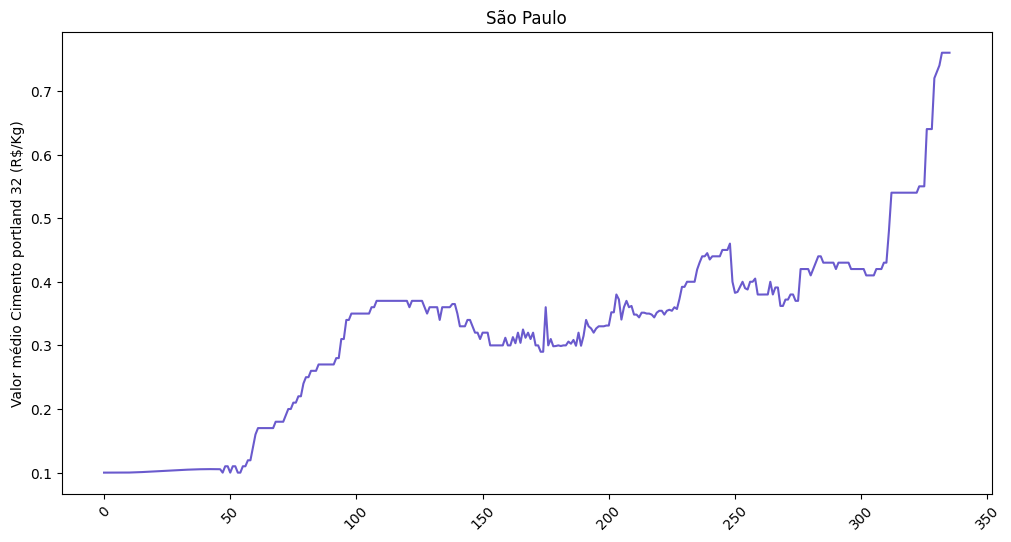

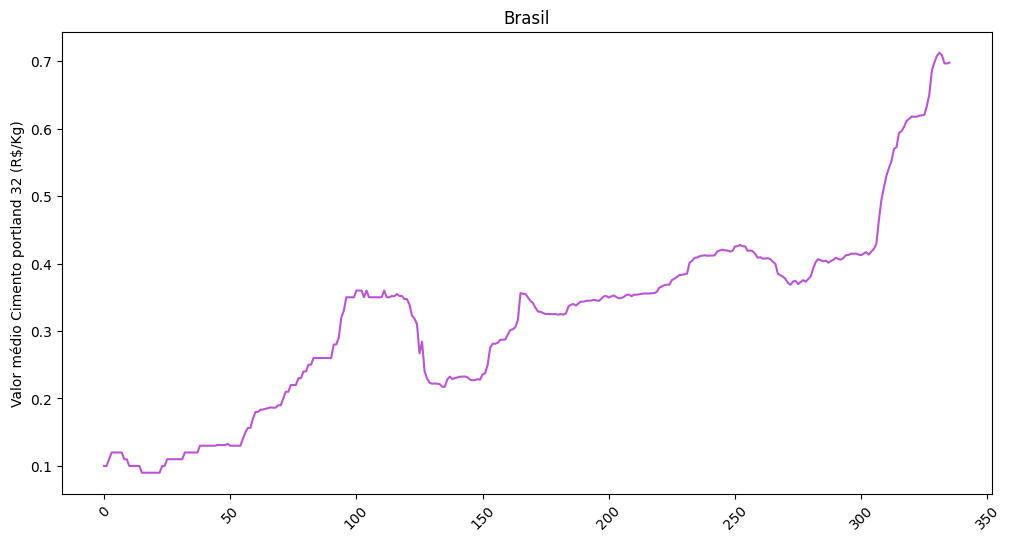

In [21]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 1:
        plot_column(df[column], color=colors[i])